# Maturity Figures  

Script to create figures for paper on age at maturity

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
#import theano as T
#import theano.tensor as tt
import seaborn as sns
import matplotlib as mp
import numpy.random as npr
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
import mpl_toolkits as mpl
import datetime as dt
from scipy.stats.kde import gaussian_kde
import matplotlib.path as mpath
import scipy as sp
from theano import shared
import sqlite3
import cmocean as co
#import joypy as jp
from matplotlib.patches import Rectangle
import palettable
import os
import pdb
mp.pyplot.style.use('ggplot')
#mp.pyplot.style.use('seaborn-darkgrid')


In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])
npm = np.median

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def SMA(array):
    return npr.choice(array)

def SMX(matrix,indx):
    return npr.choice(matrix[matrix.columns[indx]].values)

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1,lui=5,uli=95):
    if np.percentile(vector,lui)<0 and 0<np.percentile(vector,uli):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,lui),np.percentile(vector,uli)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,lui),np.percentile(vector,uli)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')
def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

# Summary functions
def CB(new,vec,obs,base,indx,valx=0):
    maxd = (base-obs)
    newd = (base-new)
    return 100-(newd/maxd)[vec[indx]!=valx]*100

def CBx(new,obs,base):
    maxd = (base-obs)
    newd = (base-new)
    return 100-(newd/maxd)*100

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

def abline(intercept,slope,col='black',alpha=1):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',c='black',alpha=alpha)

In [3]:
# upload results from model 11
# upload csv file
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
mat = pd.read_csv('mat11_model_results.csv')
mat.head()

,Unnamed: 0,a50x__0,a50x__1,a50x__2,a50x__3,a50x__4,a50x__5,a50x__6,a50x__7,a50x__8,...,mu_S__14,mu_S__15,mu_S__16,mu_S__17,mu_S__18,mu_S__19,mu_S__20,mu_S__21,mu_S__22,S2
0,0,8.519810,5.908225,7.496392,6.538182,7.871072,8.399235,7.876353,5.545394,9.795276,...,1.549132,5.097581,2.092629,2.211678,0.491263,0.668410,2.699787,4.659563,1.148019,0.008368
1,1,9.121762,5.669735,7.413088,6.446955,7.879313,8.391990,7.847920,5.881148,10.109507,...,1.562685,5.122166,2.031798,2.319250,0.496923,0.634713,2.638399,4.493892,1.151679,0.008399
2,2,9.959121,5.918222,7.351258,6.386736,8.226152,8.731709,8.246163,6.285787,10.510539,...,1.569246,5.868379,2.036634,2.285719,0.481610,0.648788,2.598248,5.056555,1.198925,0.008023
3,3,9.521028,5.159906,6.115612,5.173913,7.872682,8.364482,7.867756,7.282696,11.522197,...,1.535395,4.156503,2.154263,2.184975,0.484250,0.644315,2.621046,4.635081,1.166635,0.008574
4,4,9.838364,5.280847,6.455581,5.513547,7.616723,8.113695,7.620328,7.200869,11.449639,...,1.567608,5.099609,2.111470,2.308015,0.496353,0.663148,2.589013,4.769891,1.202072,0.008370


In [4]:
mat.columns.values

array(['Unnamed: 0', 'a50x__0', 'a50x__1', 'a50x__2', 'a50x__3',
       'a50x__4', 'a50x__5', 'a50x__6', 'a50x__7', 'a50x__8', 'a50x__9',
       'a50x__10', 'a50x__11', 'a50x__12', 'a50x__13', 'a50x__14',
       'a50x__15', 'a50x__16', 'a50x__17', 'a50x__18', 'a50x__19',
       'a50x__20', 'a50x__21', 'a50x__22', 'Lmax', 'Depth',
       'Interbirth_interval', 'Amax', 'Litter', 'Offspring_size',
       'Trophic', 'Sx__0', 'Sx__1', 'Sx__2', 'Sx__3', 'Sx__4', 'Sx__5',
       'Sx__6', 'Sx__7', 'Sx__8', 'Sx__9', 'Sx__10', 'Sx__11', 'Sx__12',
       'Sx__13', 'Sx__14', 'Sx__15', 'Sx__16', 'Sx__17', 'Sx__18',
       'Sx__19', 'Sx__20', 'Sx__21', 'Sx__22', 'K-S', 'Amax-S',
       'Trophic-S', 'Ga50', 'a50_sigma', 'GS', 'S_sigma', 'mu_a50__0',
       'mu_a50__1', 'mu_a50__2', 'mu_a50__3', 'mu_a50__4', 'mu_a50__5',
       'mu_a50__6', 'mu_a50__7', 'mu_a50__8', 'mu_a50__9', 'mu_a50__10',
       'mu_a50__11', 'mu_a50__12', 'mu_a50__13', 'mu_a50__14',
       'mu_a50__15', 'mu_a50__16', 'mu_a50__17'

## Figure 1 

Forest plot of effect sizes of covariates on a50 and S

In [5]:
# Make array of effect sizes for each covariate..
# ...for a50
Lmax = mat.Lmax.values
Depth = mat.Depth.values
Intr = mat.Interbirth_interval.values
Amax = mat.Amax.values
Litt = mat.Litter.values
Offsz = mat.Offspring_size.values
Troph = mat.Trophic.values
# .. for s
KS = mat['K-S'].values
AmaxS = mat['Amax-S'].values
TrophS = mat['Trophic-S'].values


In [6]:
# Set up data to feed into parameter plots
a50paramz = [Lmax, Depth, Intr, Amax, Litt, Offsz, Troph]
Sparamz = [KS, AmaxS, TrophS]
a50paramlabel = ['Maximum Length', 'Average Depth', 'Interbirth Interval', 'Maximum Age', 'Litter Size', 'Offspring Size', 'Trophic Level' ]
Sparamlabel = ['Growth Parameter K', 'Maximum Age', 'Trophic Level']
a50nparam = len(a50paramz)
Snparam = len(Sparamz)

In [7]:
len(mat)

2000

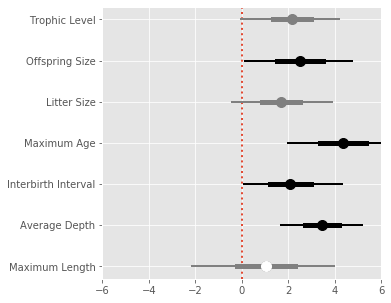

In [10]:
# Make Figure for a50
nfg = 1
fig = plt.figure(figsize=(5, 5))
gs = mp.gridspec.GridSpec(1, 1)
ax_ = [fig.add_subplot(gs[0,i]) for i in range(nfg)]

xadj = 6

for i in range(1):
    ax = ax_[i]
    ax.axvline(x=0, linestyle=':', linewidth=2)
    [gelplot(ax,a50paramz[j],j,csize=20,lwd50=5,lwd95=2) for j in range(a50nparam)]
    if i==0:
        ax.set_yticks(range(a50nparam))
        ax.set_yticklabels(a50paramlabel)
    else:
        ax.set_yticklabels('')
    ax.set_xlim(-xadj,xadj)
    ax.set_ylabel('')
    
plt.savefig('mat11_effectsize_a50.jpg', bbox_inches='tight')

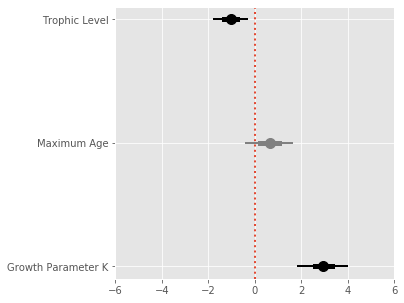

In [11]:
# Make Figure for S
nfg = 1
fig = plt.figure(figsize=(5, 5))
gs = mp.gridspec.GridSpec(1, 1)
ax_ = [fig.add_subplot(gs[0,i]) for i in range(nfg)]

xadj = 6

for i in range(1):
    ax = ax_[i]
    ax.axvline(x=0, linestyle=':', linewidth=2)
    [gelplot(ax,Sparamz[j],j,csize=20,lwd50=5,lwd95=2) for j in range(Snparam)]
    if i==0:
        ax.set_yticks(range(Snparam))
        ax.set_yticklabels(Sparamlabel)
    else:
        ax.set_yticklabels('')
    ax.set_xlim(-xadj,xadj)
    ax.set_ylabel('')
    
plt.savefig('mat11_effectsize_S.jpg', bbox_inches='tight')

In [26]:
a50paramlabel

['Maximum Length',
 'Average Depth',
 'Interbirth Interval',
 'Maximum Age',
 'Litter Size',
 'Offspring Size',
 'Trophic Level']

In [22]:
range(a50nparam)

range(0, 7)

## Figure 2 

Scatterplot for predicted and observed maturity ogives  

Do this in R

## Figure 3

Compare S and a50 predictions against main covariates. Scatter plots? Bubbles? 

Do this in R

## Figure 4

Distributions of modelled and predicted a50 and S values

In [28]:
# Aaron's colour palette for FinPrint
varpal = palettable.wesanderson.Zissou_5.hex_colors+palettable.wesanderson.Aquatic1_5.hex_colors+palettable.wesanderson.Aquatic2_5.hex_colors+palettable.wesanderson.Aquatic3_5.hex_colors

In [40]:
mat2 = mat.filter([ 'Lmax', 'Depth',
       'Interbirth_interval', 'Amax', 'Litter', 'Offspring_size',
       'Trophic', 'K-S', 'Amax-S',
       'Trophic-S'], axis=1)

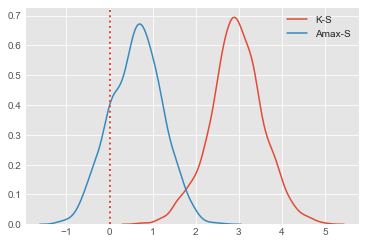

In [62]:
sns.kdeplot(data=mat2['K-S'])
sns.kdeplot(data=mat2['Amax-S'])
plt.axvline(x=0, linestyle=':', linewidth=2)

In [43]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [54]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [58]:
tips2 = tips.filter(['total_bill', 'size'], axis=1)
tips2


,total_bill,size
0,16.99,2
1,10.34,3
2,21.01,3
3,23.68,2
4,24.59,4
...,...,...
239,29.03,3
240,27.18,2
241,22.67,2
242,17.82,2


In [64]:
#sns.set_theme(style="whitegrid")

# Load the diamonds dataset
diamonds = sns.load_dataset("diamonds")

# Plot the distribution of clarity ratings, conditional on carat
sns.displot(
    data=diamonds,
    x="carat", hue="cut",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)

AttributeError: module 'seaborn' has no attribute 'displot'